# Harvest summary data from Trove lists

Using the Trove API we'll harvest some information about Trove lists and create a dataset containing the following fields:

* `id` — the list identifier, you can use this to get more information about a list from either the web interface or the API
* `title`
* `number_items` — the number of items in the list
* `created` — the date the list was created
* `updated` — the date the list was last updated

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!.</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them.</li>
        <li>To run a code cell click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>
</div>

## Setting up...

In [ ]:
import datetime
import os
import warnings
from json import JSONDecodeError
from operator import itemgetter

warnings.simplefilter(action="ignore", category=FutureWarning)

import altair as alt
import nltk
import pandas as pd
import requests_cache
from dotenv import load_dotenv
from IPython.display import HTML, display
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from textblob import TextBlob
from tqdm.auto import tqdm
from wordcloud import WordCloud

nltk.download("stopwords")
nltk.download("punkt")

s = requests_cache.CachedSession()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
s.mount("http://", HTTPAdapter(max_retries=retries))
s.mount("https://", HTTPAdapter(max_retries=retries))

load_dotenv()

## Add your Trove API key

In [19]:
# Insert your Trove API key between the quotes
API_KEY = "YOUR API KEY"

# Use api key value from environment variables if it is available
if os.getenv("TROVE_API_KEY"):
    API_KEY = os.getenv("TROVE_API_KEY")

## Set some parameters

You could change the value of `q` if you only want to harvest a subset of lists.

In [20]:
api_url = "https://api.trove.nla.gov.au/v3/result"

params = {
    "category": "list",
    "encoding": "json",
    "n": 100,
    "s": "*",
    "reclevel": "full",
    "bulkHarvest": "true",
}

headers = {"X-API-KEY": API_KEY}

## Harvest the data

In [21]:
def get_total():
    """
    This will enable us to make a nice progress bar...
    """
    response = s.get(api_url, params=params, headers=headers)
    data = response.json()
    return int(data["category"][0]["records"]["total"])

In [22]:
lists = []
total = get_total()
with tqdm(total=total) as pbar:
    while params["s"]:
        response = s.get(api_url, params=params, headers=headers)
        try:
            data = response.json()
        except JSONDecodeError:
            print(response.text)
            print(response.url)
            raise
        else:
            records = data["category"][0]["records"]
            try:
                params["s"] = records["nextStart"]
            except KeyError:
                params["s"] = None
            for record in records["list"]:
                try:
                    lists.append(
                        {
                            "id": record["id"],
                            "title": record.get("title", ""),
                            "number_items": record["listItemCount"],
                            "created": record["date"]["created"],
                            "updated": record["date"]["lastupdated"],
                        }
                    )
                except TypeError:
                    print(record)
            pbar.update(100)

  0%|          | 0/111965 [00:00<?, ?it/s]

None
None
None
None
None


## Inspect the results

In [5]:
# Load past file for testing if in dev
if os.getenv("GW_STATUS") and os.getenv("GW_STATUS") == "dev":
    df = pd.read_csv("data/trove-lists-2024-05-29.csv")
# Otherwise load current harvested data
else:
    df = pd.DataFrame(lists)
    df.head()

In [6]:
df.describe()

id   number_items
count  111960.000000  111960.000000
mean    89844.496008      19.163433
std     50142.898174      83.319781
min        51.000000       0.000000
25%     47114.500000       1.000000
50%     90193.500000       4.000000
75%    132493.750000      13.000000
max    179448.000000   10351.000000

## Save the harvested data as a CSV file

In [ ]:
csv_file = "data/trove-lists-{}.csv".format(datetime.datetime.now().isoformat()[:10])
df.to_csv(csv_file, index=False)
HTML('<a target="_blank" href="{}">Download CSV</a>'.format(csv_file))

## How many items are in lists?

In [7]:
total_items = df["number_items"].sum()
print("There are {:,} items in {:,} lists.".format(total_items, df.shape[0]))

There are 2,145,538 items in 111,960 lists.


## What is the biggest list?

In [8]:
biggest = df.iloc[df["number_items"].idxmax()]
biggest

id                                  71461
title           Victoria and elsewhere...
number_items                        10351
created              2015-04-03T11:50:51Z
updated              2016-02-22T04:27:12Z
Name: 91223, dtype: object

In [9]:
display(
    HTML(
        'The biggest list is <a target="_blank" href="https://trove.nla.gov.au/list?id={}">{}</a> with {:,} items.'.format(
            biggest["id"], biggest["title"], biggest["number_items"]
        )
    )
)

## When were they created?

In [10]:
# This makes it possible to include more than 5000 records
# alt.data_transformers.enable('json', urlpath='files')
alt.data_transformers.disable_max_rows()
alt.Chart(df[["created"]]).mark_line().encode(
    x="yearmonth(created):T",
    y="count()",
    tooltip=[
        alt.Tooltip("yearmonth(created):T", title="Month"),
        alt.Tooltip("count()", title="Lists"),
    ],
).properties(width=600)

alt.Chart(...)

## What words are used in the titles?

In [11]:
titles = df["title"].str.lower().str.cat(sep=" ")

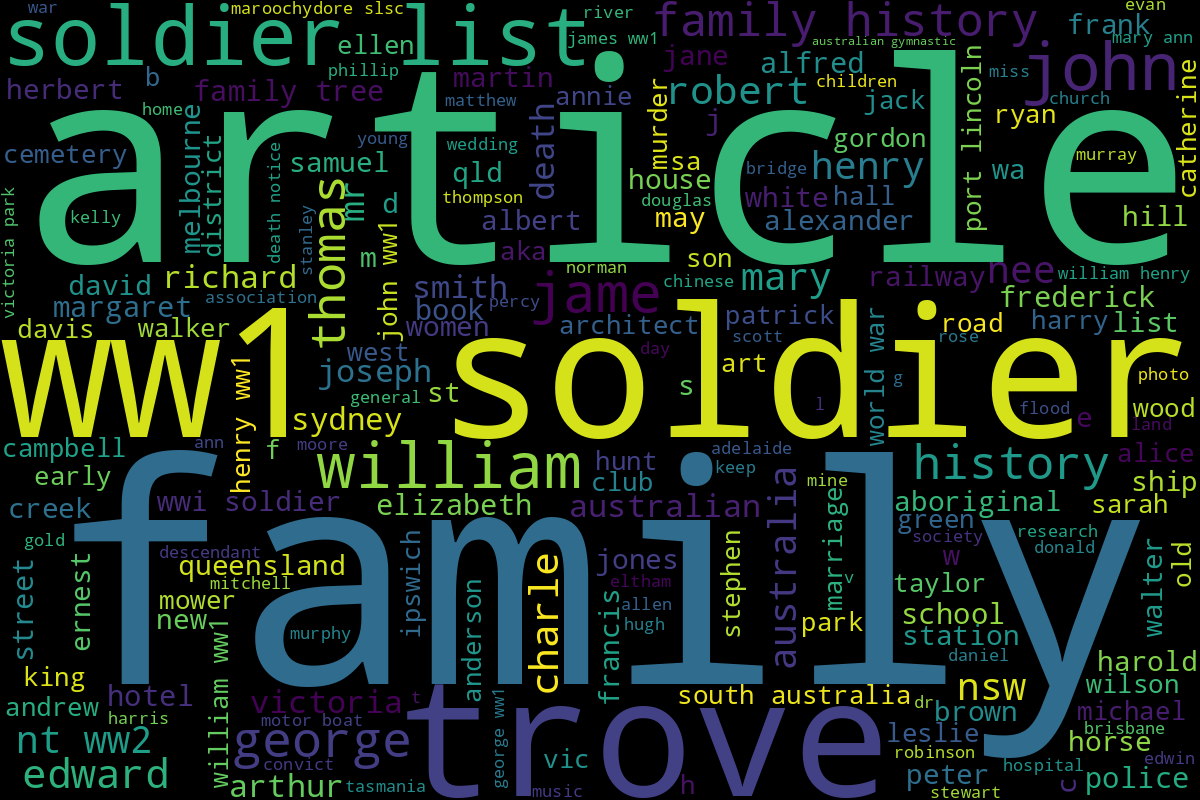

In [12]:
# Generate a word cloud image
wordcloud = WordCloud(width=1200, height=800).generate(titles)
wordcloud.to_image()

### Word frequency

In [13]:
blob = TextBlob(titles)
stopwords = nltk.corpus.stopwords.words("english")
word_counts = [
    [word, count]
    for word, count in blob.lower().word_counts.items()
    if word not in stopwords
]
word_counts = sorted(word_counts, key=itemgetter(1), reverse=True)[:25]
pd.DataFrame(word_counts).style.format({1: "{:,}"}).bar(
    subset=[1], color="#d65f5f"
).set_properties(subset=[1], **{"width": "300px"})

### Bigram frequency

In [14]:
ngrams = [" ".join(ngram).lower() for ngram in blob.lower().ngrams(2)]
ngram_counts = (
    pd.DataFrame(ngrams)[0]
    .value_counts()
    .rename_axis("ngram")
    .reset_index(name="count")
)
display(
    ngram_counts[:25]
    .style.format({"count": "{:,}"})
    .bar(subset=["count"], color="#d65f5f")
    .set_properties(subset=["count"], **{"width": "300px"})
)

### Trigram frequency

In [15]:
ngrams = [" ".join(ngram).lower() for ngram in blob.lower().ngrams(3)]
ngram_counts = (
    pd.DataFrame(ngrams)[0]
    .value_counts()
    .rename_axis("ngram")
    .reset_index(name="count")
)
display(
    ngram_counts[:25]
    .style.format({"count": "{:,}"})
    .bar(subset=["count"], color="#d65f5f")
    .set_properties(subset=["count"], **{"width": "300px"})
)

----

Created by [Tim Sherratt](https://timsherratt.org/) for the [GLAM Workbench](https://glam-workbench.github.io/).